# Lab Assignment Three: Extending Logistic Regression
by:
* Hayden Donofrio
* Riley Bates
* Chandler Choate

## Section 1: Preparation and Overview

### Business Case

The dataset that we chose for this lab is called [Intel Image Classification](https://www.kaggle.com/puneet6060/intel-image-classification), and is comprised of around 25,000 scenery images around the world broken into different categories: buildings, forests, glaciers, mountains, seas, and streets. One of the main reasons for neural networks is to help the process of grouping and classifying the data given. This process can save a lot of time because you are not having to separate each item, one by one, to the correct section. Our model, if successful, could be incredibly useful in the fields of reconnaissance and satellite imagery. Our model could be used to group and sort thousands of different images into different types of landscapes before the images are touched by human hands, saving analysts the time of sifting through all these images. For example, if an analyst is looking for possible locations based on existing imagery data, they could search through the already classified mountainous or desert region imagery.

However, one limitation is the fact that most of our image dataset is not taken from an aerial view, so the model may not perform well when given satellite imagery as input, but would still perform as expected when used with other images of the scenery. Our model could also possibly be used by photojournalism companies as an initial classifier, and with further work on the model, we may be able to recognize the same scene in various images, such as recognizing two different images of Reunion Tower in Dallas.

This model would need to perform quite highly in order to be able to make a difference compared to what is already out there. If this network is not performing up to par with similar algorithms then the function is useless. This multi-layer perception would need to perform in the top percentiles of time and accuracy for interested parties to even want to take a look at this algorithm. In today’s world, many companies, if not all, have deadlines and if the process takes too long to classify and is not correctly sorting, then why take the time to test it on your specific needs. Overall for this prediction algorithm to be useful, it will need to be accurate and time efficient with unique and close to perfect results/models to back up tasks at hand.

Dataset Source: https://www.kaggle.com/puneet6060/intel-image-classification

### Prepare Data

In [129]:
#steps for reading images ->
#merge the folders in the test and train folders together and then move it to be the only folders in the `intel-image-classification` directory
#in the end you should have the intel-image-classification folder and a few folders that say forest, city, etc...
#steps... mix the two sets together
#FOR NOW JUST USE THE LOAD FROM DOWN BELOW FOR TESTING
yourpath = 'intel-image-classification'
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import contextlib
import os
import cv2
images = {}
X = []
y = []
list_counter = -1
strs = []
for root, dirs, files in os.walk(yourpath, topdown=False):
    for name in files:
        try:
            regx = re.compile("[a-zA-Z]+$")
            image = cv2.imread(os.path.join(root, name),0)
            image = cv2.resize(image,(150,150))
            image = (image.flatten())
            key = regx.search(root).group(0)
            if key not in strs:
                strs.append(key)
                list_counter += 1
            image = (image/255.0 - .5)
            X.append(image)
            y.append(list_counter)
        except:
            #print("SJIP")
            continue

In [130]:
Xp = []
for i in X:
    Xp.append(i.reshape(1,22500))
X = np.array(Xp).reshape(len(Xp),22500)
print(X.shape)

(17034, 22500)


(17034, 22500)


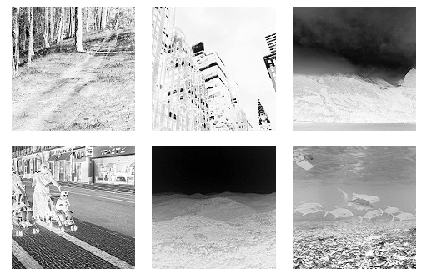

In [134]:
fig, ax = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True,)
ax = ax.flatten()
y = np.array(y)
print(X.shape)
for i in range(6):
#     print(X[0])
    img = X[y == i][0].reshape(150,150)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

### Dataset Description

The dataset is now comprised of resized, greyscale images that are encoded based on location. We have around 17,000 images in our dataset now. Let's take a look at how this is broken up between classes.

In [133]:
#I do not think K-fold will help us much. Why? We have plenty of data for each class. Lets see how big each class is to prove it
unique, counts = np.unique(y, return_counts=True)
print(np.asarray((unique, counts)).T)
#print((X).reshape(17034, 22500))

[[   0 2745]
 [   1 2628]
 [   2 2957]
 [   3 2883]
 [   4 3037]
 [   5 2784]]


Since we have plenty of data for each class, we may not need to implement K-folds, and would be alright using a test/train split.

For classifying this dataset, we didn't think that accuracy was the best measure of how well the model performed. We did some research on ways to evaluate neural networks (read [this](https://jenstirrup.com/2017/08/01/how-do-you-evaluate-the-performance-of-a-neural-network-focus-on-azureml/) and [this](https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9)) and decided that using F1 score would be a good evaluation metric, because we want a good balance between precision and recall.

In [135]:
#lets use an 80/20 split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.8)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3406, 22500)
(3406,)
(13628, 22500)
(13628,)


## MLP Implementation

In [136]:
# Example adapted from https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch12/ch12.ipynb
# Original Author: Sebastian Raschka

# This is the optional book we use in the course, excellent intuitions and straightforward programming examples
# please note, however, that this code has been manipulated to reflect our assumptions and notation.
import numpy as np
from scipy.special import expit
import sys
import pandas as pd

# start with a simple base classifier, which can't be fit or predicted
# it only has internal classes to be used by classes that will subclass it
class TwoLayerPerceptronBase(object):
    def __init__(self, n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None, steps=2, phi="sigmoid", cost="quad"):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        self.steps = steps
        self.phi = phi
        self.cost= cost
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        Ws = []
        W1_num_elems = (self.n_features_ + 1)*self.n_hidden
        W1 = np.random.uniform(-1.0, 1.0, size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden, self.n_features_ + 1) # reshape to be W
        Ws.append(W1)
        for i in range(1, self.steps):
            if i +1 == self.steps:
                W2_num_elems = (self.n_hidden + 1)*self.n_output_
                W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
                W2 = W2.reshape(self.n_output_, self.n_hidden + 1)
                Ws.append(W2)
            else:
                W_num_elems = ((Ws[i-1].shape[0]+1)*(self.n_hidden))
                W = np.random.uniform(-1.0, 1.0, size=W_num_elems)
                W = W.reshape(self.n_hidden, Ws[i-1].shape[0]+1)
                Ws.append(W)
        return Ws
    
    @staticmethod
    def _sigmoid(z):
        # we should also have a linear function too
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    @staticmethod
    def _linear(z):
        print("LINEAR")
        return z
    
    def _phi(self, z):
        if self.phi == "sigmoid":
            return expit(z)
        elif self.phi == "linear":
            return z
        else:
            print >> sys.stderr, "Not a valid phi function (linear or sigmoid)"
            sys.exit(1)
            
    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    @staticmethod
    def _L2_reg(lambda_, Ws):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        means = 0
        for w in Ws:
            means += np.mean(w[:, 1:] ** 2)
        #Maybe?? Check this
        return (lambda_/len(Ws)) * (means)**(1/len(Ws))
    
    def _cost(self,A3,Y_enc,Ws):
        '''Get the objective function value'''
        #A3 = yhat
        cost = 0
        if self.cost == "cross":
            cost = -np.mean(Y_enc * np.log(A3) + (1-Y_enc)*np.log(1-A3))
        elif self.cost == "quad":
            cost = np.mean((Y_enc-A3)**2)
        else:
              print >> sys.stderr, "Not a valid cost function (quad or cross)"
              sys.exit(1)
        
        L2_term = self._L2_reg(self.l2_C, Ws)
        return cost + L2_term
    

In [137]:
class TwoLayerPerceptron(TwoLayerPerceptronBase):
    def _feedforward(self, X, Ws):
        """Compute feedforward step
        -----------
        X : Input layer with original features.
        W1: Weight matrix for input layer -> hidden layer.
        W2: Weight matrix for hidden layer -> output layer.
        ----------
        a1-a3 : activations into layer (or output layer)
        z1-z2 : layer inputs 

        """
        As = [None]*(self.steps+1)
        Zs = [None]*self.steps
        for i in range(len(As)):
            if i==0:
                As[0] = self._add_bias_unit(X, how='column')
                As[0] = As[0].T
            else:
                Zs[i-1] = Ws[i-1] @ As[i-1]
                if i!=len(As)-1:
                    As[i] = self._phi(Zs[i-1])
                    As[i] = self._add_bias_unit(As[i], how='row')
                else:
                    As[i] = self._phi(Zs[i-1])
        return As, Zs

    def predict(self, X):
        """Predict class labels"""
        As, Zs = self._feedforward(X, self.Ws)
        y_pred = np.argmax(As[-1], axis=0)
        return y_pred
    
    
    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data."""
        
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.Ws = self._initialize_weights()

        self.cost_ = []
        for i in range(self.epochs):

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            # feedforward all instances
            As, Zs = self._feedforward(X_data,self.Ws)
            
            cost = self._cost(As[-1],Y_enc,self.Ws)
            self.cost_.append(cost)

            # compute gradient via backpropagation
            grads = self._get_gradient(As=As, Zs=Zs, Y_enc=Y_enc,
                                              Ws=self.Ws)
            for j in range(len(grads)):
                k = self.eta * grads[j]
                self.Ws[j] -= self.eta * grads[j]
            

        return self

In [138]:
class TwoLayerPerceptronVectorized(TwoLayerPerceptron):
    # just need a different gradient calculation
    def _get_gradient(self, As, Zs, Y_enc, Ws):
        """ Compute gradient step using backpropagation.
        """
        Vs = []
        grads = []
        for i in reversed(range(1,self.steps+1)):
            if self.cost == "quad":
                if i == self.steps:
                    v_last = -2*(Y_enc-As[i])*As[i]*(1-As[i])
                    grad_last = v_last @ As[i-1].T
                    Vs.append(v_last)
                    grads.append(grad_last)
                elif self.steps > 2 and i <= self.steps - 2 and i > 0:
                    V = None
                    if self.phi == 'sigmoid':
                        V = As[i]*(1-As[i])*(Ws[i].T @ Vs[0][1:,:])
                    elif self.phi == 'linear':
                        V = Ws[i].T @ Vs[0][1:,:]
                    Vs.insert(0,V)
                else:
                    V = None
                    if self.phi == 'sigmoid':
                        V = As[i]*(1-As[i])
                        V *= Ws[i].T @ Vs[0]
                    elif self.phi == 'linear':
                        V = Ws[i].T @ Vs[0]
                    Vs.insert(0,V)
            else:
                if i==self.steps:
                    V = As[i]-Y_enc
                    Vs.insert(0,V)
                elif self.steps > 2 and i <= self.steps - 2 and i > 0:
                    V = None
                    if self.phi == 'sigmoid':
                        V = As[i]*(1-As[i])*(Ws[i].T @ Vs[0][1:,:])
                    elif self.phi == 'linear':
                        V = Ws[i].T @ Vs[0][1:,:]
                    Vs.insert(0,V)
                else:
                    V = None
                    if self.phi == 'sigmoid':
                        V = As[i]*(1-As[i])*(Ws[i].T @ Vs[0])
                    elif self.phi == 'linear':
                        V = Ws[i].T @ Vs[0]
                    Vs.insert(0,V)

        for i in reversed(range(0,len(Vs)-1)):
            grad = Vs[i][1:,:] @ As[i].T
            grad[:,1:] += Ws[i][:, 1:] * self.l2_C
            grads.insert(0,grad)
        
        return grads
    
    def get_params(self, deep=True):
        return {"n_hidden": self.n_hidden, 
                "epochs": self.epochs,
                "eta": self.eta, 
                "steps": self.steps,
                "phi": self.phi}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

# Testing on Digit Data

In [26]:
###TESTING DATA
# lets load up the handwritten digit dataset
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import numpy as np

ds = load_digits()
print(ds.data)
X = ds.data/16.0-0.5
print(X)
y = ds.target
print(y)
print(X.shape)
print(y.shape)
print(np.min(X),np.max(X))
print(np.unique(y))
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2)
# print(X_train.shape)
# print(y_train.shape)
# print(X_test.shape)
# print(y_test.shape)

[[ 0.  0.  5. ...  0.  0.  0.]
 [ 0.  0.  0. ... 10.  0.  0.]
 [ 0.  0.  0. ... 16.  9.  0.]
 ...
 [ 0.  0.  1. ...  6.  0.  0.]
 [ 0.  0.  2. ... 12.  0.  0.]
 [ 0.  0. 10. ... 12.  1.  0.]]
[[-0.5    -0.5    -0.1875 ... -0.5    -0.5    -0.5   ]
 [-0.5    -0.5    -0.5    ...  0.125  -0.5    -0.5   ]
 [-0.5    -0.5    -0.5    ...  0.5     0.0625 -0.5   ]
 ...
 [-0.5    -0.5    -0.4375 ... -0.125  -0.5    -0.5   ]
 [-0.5    -0.5    -0.375  ...  0.25   -0.5    -0.5   ]
 [-0.5    -0.5     0.125  ...  0.25   -0.4375 -0.5   ]]
[0 1 2 ... 8 9 8]
(1797, 64)
(1797,)
-0.5 0.5
[0 1 2 3 4 5 6 7 8 9]
(1437, 64)
(1437,)
(360, 64)
(360,)


Let's see how it does!

In [139]:
params = dict(n_hidden=50, 
              C=0.1, # tradeoff L2 regularizer
              epochs=200, # iterations
              eta=0.001,  # learning rate
              random_state=1,
             steps=4,
             phi="sigmoid",
             cost="quad")

In [ ]:
%%time
from sklearn.metrics import accuracy_score
params['epochs'] = 2000
nn = TwoLayerPerceptronVectorized(**params)
nn.fit(X_train, y_train, print_progress=50)
yhat = nn.predict(X_test)
print('Accuracy:',accuracy_score(y_test,yhat))

Epoch: 400/2000

Now let's compare our MLP implementation with SKLearn's.

## SKLearn MLP

In [101]:
from sklearn import __version__ as sklearn_version
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# these values have been hand tuned
clf = MLPClassifier(hidden_layer_sizes=(50, ), 
                    activation='logistic', 
                    solver='sgd', 
                    alpha=1e-4, # L2 penalty
                    batch_size='auto', # min of 200, num_samples
                    learning_rate='constant', 
                    learning_rate_init=0.1, # only SGD
                    power_t=0.5,    # only SGD
                    max_iter=75, 
                    shuffle=False, 
                    random_state=1, 
                    tol=1e-9, # for stopping
                    verbose=False, 
                    warm_start=False, 
                    momentum=0.9, # only SGD
                    nesterovs_momentum=True, # only SGD
                    early_stopping=True, 
                    validation_fraction=0.1, # only if early_stop is true
                    beta_1=0.9, # adam decay rate of moment
                    beta_2=0.999, # adam decay rate of moment
                    epsilon=1e-08) # adam numerical stabilizer

%time clf.fit(X_train,y_train)
print(clf.n_layers_)
yhat = clf.predict(X_test)
print('Validation Acc:',accuracy_score(yhat,y_test))

CPU times: user 415 ms, sys: 83.9 ms, total: 499 ms
Wall time: 131 ms
3
Validation Acc: 0.9083333333333333


## Hyper Parameter Tuning

We can probably achieve higher performance if we fine tune the parameters a bit. We'll use a grid search to find the best parameters between the phi function for the initial layer (either sigmoid or linear), the cost function (either mean squared error or cross entropy), and the number of hidden layers used in the MLP.

### Compare: 
phi = sigmoid or linear <br>
cost = quad or cross <br>
number of layers: 2,3,5

In [126]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

param_grid = {'phi': ['sigmoid', 'linear'], 
              'cost': ['quad', 'cross'],
              'n_hidden':[2,3,5]}

mlp = TwoLayerPerceptronVectorized()

# for i in range(len(ParameterGrid(param_grid))):
#     print('\n',ParameterGrid(param_grid)[i])

gs = GridSearchCV(estimator=mlp,
                 param_grid=param_grid,
                 scoring='f1',
                 cv=2)
# gs.fit(X_train, y_train)
# print('Best parameters found:\n', gs.best_params_)


# scores = cross_val_score(gs, X_train, y_train, scoring = 'f1', cv=6)
# print('CV accuracy: %.3f +/- %.3f' %(np.mean(scores), np.std(scores)))

In [127]:
# brute force parameter search
for n in range(len(param_grid['n_hidden'])):
    for c in range(len(param_grid['cost'])):
        for p in range(len(param_grid['phi'])):
            nn = TwoLayerPerceptronVectorized(n_hidden=param_grid['n_hidden'][n], 
                  C=0.1,  
                  epochs=20, 
                  eta=0.001,  
                  phi=param_grid['phi'][p],
                  cost=param_grid['cost'][c],
                  random_state=1,
                  steps=4,
                  )
            nn.fit(X_train, y_train)
            yhat = nn.predict(X_test)
            print('\n\nHidden layers:',param_grid['n_hidden'][n])
            print('\nPhi:',param_grid['phi'][p])
            print('\nCost function:',param_grid['cost'][c])
            print('\nAccuracy:',accuracy_score(y_test,yhat))



Hidden layers: 2

Phi: sigmoid

Cost function: quad

Accuracy: 0.11388888888888889


Hidden layers: 2

Phi: linear

Cost function: quad

Accuracy: 0.1


Hidden layers: 2

Phi: sigmoid

Cost function: cross

Accuracy: 0.11388888888888889


Hidden layers: 2

Phi: linear

Cost function: cross

Accuracy: 0.1


Hidden layers: 3

Phi: sigmoid

Cost function: quad

Accuracy: 0.09444444444444444


Hidden layers: 3

Phi: linear

Cost function: quad

Accuracy: 0.1


Hidden layers: 3

Phi: sigmoid

Cost function: cross

Accuracy: 0.08611111111111111


Hidden layers: 3

Phi: linear

Cost function: cross

Accuracy: 0.1


Hidden layers: 5

Phi: sigmoid

Cost function: quad

Accuracy: 0.06111111111111111


Hidden layers: 5

Phi: linear

Cost function: quad

Accuracy: 0.1


Hidden layers: 5

Phi: sigmoid

Cost function: cross

Accuracy: 0.09444444444444444


Hidden layers: 5

Phi: linear

Cost function: cross

Accuracy: 0.1


## Visualization

### Custom MLP with cross entropy vs quadratic

In [74]:
params_cross = dict(n_hidden=2, 
              C=0.1, # tradeoff L2 regularizer
              epochs=200, # iterations
              eta=0.001,  # learning rate
              random_state=1,
              steps=4,
              phi="sigmoid",
              cost="cross")

params_quad = dict(n_hidden=2, 
              C=0.1, # tradeoff L2 regularizer
              epochs=200, # iterations
              eta=0.001,  # learning rate
              random_state=1,
              steps=4,
              phi="sigmoid",
              cost="quad")

nn_quad = TwoLayerPerceptronVectorized(**params_quad)

nn_cross = TwoLayerPerceptronVectorized(**params_cross)

%time nn_cross.fit(X_train, y_train, print_progress=1)
%time nn_quad.fit(X_train, y_train, print_progress=1)
print("Done")

Epoch: 104/200

CPU times: user 419 ms, sys: 61.4 ms, total: 480 ms
Wall time: 435 ms


Epoch: 200/200

CPU times: user 378 ms, sys: 59.1 ms, total: 437 ms
Wall time: 395 ms
Done


In [115]:
def calc_epochs(params, X_train, y_train, X_test, y_test):
    epochs = []
    for epoch in list(range(1, 200, 25)):
        nn = TwoLayerPerceptronVectorized(**params)
        nn.fit(X_train, y_train)
        yhat = nn.predict(X_test)
        score1 = f1_score(y_test, yhat, average='macro')
        epochs.append([score1, epoch])
#         print(score1, epoch)
    return epochs

0.9565908983923135 1
0.9565908983923135 26
0.9565908983923135 51
0.9565908983923135 76
0.9565908983923135 101
0.9565908983923135 126
0.9565908983923135 151
0.9565908983923135 176
0.9585958437503288 1
0.9585958437503288 26
0.9585958437503288 51
0.9585958437503288 76
0.9585958437503288 101
0.9585958437503288 126
0.9585958437503288 151
0.9585958437503288 176


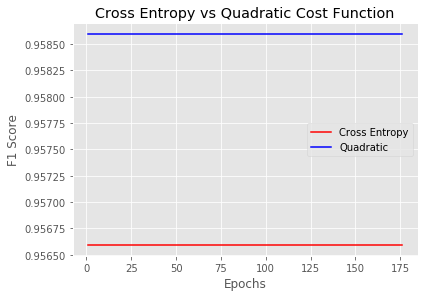

In [111]:
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score

params = dict(n_hidden=50, 
                  C=0.1,  # tradeoff L2 regularizer
                  epochs=epoch, # iterations
                  eta=0.001,  # learning rate
                  random_state=1,
                  steps=4,
                  phi="sigmoid",
                  cost="cross")
epochs_cross = calc_epochs(params, X_train, y_train, X_test, y_test)
epochs_cross = np.array(epochs_cross)

params = dict(n_hidden=50, 
                  C=0.1,  # tradeoff L2 regularizer
                  epochs=epoch, # iterations
                  eta=0.001,  # learning rate
                  random_state=1,
                  steps=4,
                  phi="sigmoid",
                  cost="quad")
epochs_quad = calc_epochs(params, X_train, y_train, X_test, y_test)
epochs_quad = np.array(epochs_quad)

plt.style.use('ggplot')

plt.plot(epochs_cross[:,1], epochs_cross[:,0], color='red',label='Cross Entropy')
plt.plot(epochs_quad[:,1], epochs_quad[:,0], color='blue',label='Quadratic')
plt.ylabel('F1 Score')
plt.xlabel('Epochs')
plt.tight_layout()
plt.legend(loc='best')
plt.grid(True)
plt.title("Cross Entropy vs Quadratic Cost Function")
plt.show()

### Custom MLP with Linear vs Sigmoid Phi Function

0.9565908983923135 1
0.9565908983923135 26
0.9565908983923135 51
0.9565908983923135 76
0.9565908983923135 101
0.9565908983923135 126
0.9565908983923135 151
0.9565908983923135 176


//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.01818181818181818 1
0.01818181818181818 26
0.01818181818181818 51
0.01818181818181818 76
0.01818181818181818 101
0.01818181818181818 126
0.01818181818181818 151
0.01818181818181818 176


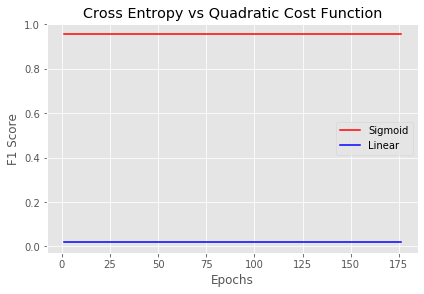

In [114]:
import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)

params = dict(n_hidden=50, 
                  C=0.1,  # tradeoff L2 regularizer
                  epochs=epoch, # iterations
                  eta=0.001,  # learning rate
                  random_state=1,
                  steps=4,
                  phi="sigmoid",
                  cost="cross")
epochs_sigmoid = calc_epochs(params, X_train, y_train, X_test, y_test)
epochs_sigmoid = np.array(epochs_sigmoid)

params = dict(n_hidden=50, 
                  C=0.1,  # tradeoff L2 regularizer
                  epochs=epoch, # iterations
                  eta=0.001,  # learning rate
                  random_state=1,
                  steps=4,
                  phi="linear",
                  cost="cross")
epochs_linear = calc_epochs(params, X_train, y_train, X_test, y_test)
epochs_linear = np.array(epochs_linear)

plt.style.use('ggplot')

plt.plot(epochs_sigmoid[:,1], epochs_sigmoid[:,0], color='red',label='Sigmoid')
plt.plot(epochs_linear[:,1], epochs_linear[:,0], color='blue',label='Linear')
plt.ylabel('F1 Score')
plt.xlabel('Epochs')
plt.tight_layout()
plt.legend(loc='best')
plt.grid(True)
plt.title("Cross Entropy vs Quadratic Cost Function")
plt.show()

As shown above, using a linear phi function results in very, very low performance that does not improve in later epochs. Using a sigmoid phi function is recommended over this, although in real practice, we would likely implement another method such as ReLU or SiLU.

In [52]:
#TEST WITHOUT FOLDS THIS IS A TEST USING 80/20 SPLITS. 
#THE COMMENTED OUT SECTION BELOW IS HOW TO DO ALL OF THESE CHARTS USING FOLDS IF NEEDED
epochs = []
for epoch in list(range(20, 700, 25)):
    params = dict(n_hidden=50, 
                  C=0.1,  # tradeoff L2 regularizer
                  epochs=epoch, # iterations
                  eta=0.001,  # learning rate
                  random_state=1,
                 steps=4,
                 phi="sigmoid",
                 cost="quad")
    nn = TwoLayerPerceptronVectorized(**params)
    nn.fit(X_train, y_train)
    yhat = nn.predict(X_test)
    score1 = f1_score(y_test, yhat, average='macro')
    epochs.append([score1, epoch])
    print(score1, epoch)


//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.10366884726530394 20
0.23629939078530562 45
0.31410040154971625 70
0.5007322088304371 95
0.5277106709640408 120
0.7757359831371415 145
0.8341529779634673 170
0.9039275673976774 195
0.8984015044880602 220
0.9316440233723966 245
0.9365741791566148 270
0.9392351193732689 295
0.9415926823743133 320
0.9469895640420114 345
0.9526123074899815 370
0.9526123074899815 395
0.9526123074899815 420
0.9555382439025802 445
0.9555382439025802 470
0.9555382439025802 495
0.9531649273579136 520
0.9564370530198552 545
0.9561876045216369 570
0.9561876045216369 595
0.9585958437503288 620
0.9585958437503288 645
0.9585958437503288 670
0.9585958437503288 695


[0.10183526 0.24009334 0.3317764  0.44325585 0.69992859 0.7703328
 0.90556804 0.8929868  0.93211277 0.94085768 0.95586363 0.96109945
 0.96109945 0.96350928 0.96928996 0.9718961  0.9718961  0.97208518
 0.97208518 0.97208518 0.97510822 0.97510822 0.97811462 0.97811462
 0.97811462 0.97800928 0.97800928 0.97800928 0.97800928 0.97800928
 0.97800928 0.97800928 0.97800928 0.97800928 0.97800928 0.97800928
 0.97800928 0.97800928 0.97800928 0.97800928]
Figure(432x288)


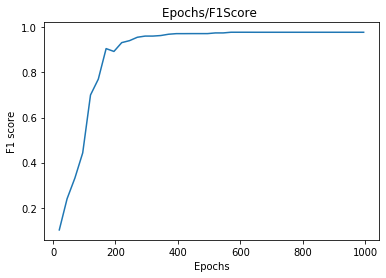

In [317]:
import matplotlib.pyplot as plt
epochs = np.array(epochs)
print(epochs[:,0])
fig = plt.figure()
print(fig)
plt.scatter(epochs[:,1],epochs[:,0], marker="")
plt.plot(epochs[:,1], epochs[:,0])
plt.xlabel("Epochs")
plt.ylabel("F1 score")
plt.title("Epochs/F1Score ")
plt.show()


20
70
120
170
220
270
320
370
420
470
520
570
620
670


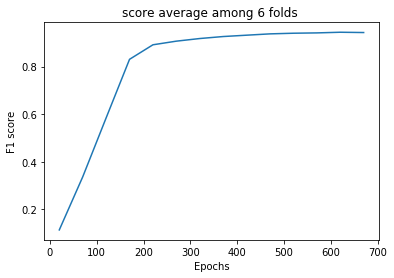

In [324]:
from sklearn.model_selection import KFold, ShuffleSplit
#THIS IS HOW TO DO ONE OF THE GRAPHS BY FOLDS
cv = KFold(n_splits=6)
epoch_s = []
for epoch in list(range(20, 700, 50)):
    scores = []
    for train_i, test_i in cv.split(X):
        params = dict(n_hidden=50, 
                  C=0.1, # tradeoff L2 regularizer
                  epochs=epoch, # iterations
                  eta=0.001,  # learning rate
                  random_state=1,
                 steps=4,
                 phi="sigmoid",
                 cost="quad")
        nn = TwoLayerPerceptronVectorized(**params)
        nn.fit(X[train_i], y[train_i])
        yhat = nn.predict(X[test_i])
        score1 = f1_score(y[test_i], yhat, average='macro')
        scores.append(score1)
    print(epoch)
    epoch_s.append([np.mean(scores), epoch])
epoch_s = np.array(epoch_s)
fig = plt.figure()
plt.scatter(epoch_s[:,1],epoch_s[:,0], marker="")
plt.plot(epoch_s[:,1], epoch_s[:,0])
plt.xlabel("Epochs")
plt.ylabel("F1 score")
plt.title("score average among 6 folds ")
plt.show()


### Custom MLP Implementation vs SKLearn Implementation

In [118]:
# Timing
# these values have been hand tuned
clf = MLPClassifier(hidden_layer_sizes=(50, ), 
                    activation='logistic', 
                    solver='sgd', 
                    alpha=1e-4, # L2 penalty
                    batch_size='auto', # min of 200, num_samples
                    learning_rate='constant', 
                    learning_rate_init=0.1, # only SGD
                    power_t=0.5,    # only SGD
                    max_iter=75, 
                    shuffle=False, 
                    random_state=1, 
                    tol=1e-9, # for stopping
                    verbose=False, 
                    warm_start=False, 
                    momentum=0.9, # only SGD
                    nesterovs_momentum=True, # only SGD
                    early_stopping=True, 
                    validation_fraction=0.1, # only if early_stop is true
                    beta_1=0.9, # adam decay rate of moment
                    beta_2=0.999, # adam decay rate of moment
                    epsilon=1e-08) # adam numerical stabilizer

%time clf.fit(X_train,y_train)
yhat = clf.predict(X_test)
print('SKLearn Validation Accuracy:',accuracy_score(yhat,y_test),'\n\n')


nn = TwoLayerPerceptronVectorized(n_hidden=50, 
                      C=0.1, # tradeoff L2 regularizer
#                       epochs=200, # iterations
                      eta=0.001,  # learning rate
                      random_state=1,
                      steps=4,
                      phi="sigmoid",
                      cost="quad")
%time nn.fit(X_train, y_train)
yhat = nn.predict(X_test)
print('Custom MLP Validation Accuracy:',accuracy_score(yhat,y_test))

CPU times: user 399 ms, sys: 76.8 ms, total: 476 ms
Wall time: 121 ms
SKLearn Validation Accuracy: 0.9083333333333333 


CPU times: user 8.73 s, sys: 1.12 s, total: 9.85 s
Wall time: 2.47 s
Custom MLP Validation Accuracy: 0.9583333333333334


In [ ]:
# visualize gradient
ax = plt.subplot(1,1,1)
plt.plot(abs(clf.grad_w1_[10:]), label='w1')
plt.plot(abs(clf.grad_w2_[10:]), label='w2')
plt.legend()
plt.ylabel('Average gradient magnitude')
plt.xlabel('Iteration')
plt.show()

## Section 4: Exceptional Work

All three of our group members participated in the Biometrics research study.